In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import IntegerLookup
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [105]:
import tensorflow_datasets as tfds


In [14]:
df_pre = pd.read_csv("data/formatted_medical7_aug5.csv",header=0, sep="\,")
selected_features = np.load("f4.npy")
# drop first columns as they are redundant 
df_pre.drop('Unnamed: 0', axis = 1, inplace = True)

#keep only selected columns
target ="Graft loss 1 year"
df_pre = df_pre[[target] + list(selected_features)]

discrete_columns = [
    'AB and Dr mismatch',
    'AKI - KDIGO 2012',
    'Acute RRT initiation',
    'Another urosepsis 1 year',
    'Charlston Comorbidity Index',
    'Donor',
    'FSGS',
    'GCS',
    'Induction',
    'Next UTI - 6 months',
    'Reduction 3--> 2',
    'Reduction to steroid only',
    'Steroid bolus',
    'Transfusion [YES/NO]',
    'Tripple maintenance therapy before admission',
    'Urinary sepsis'
]


feature_map = {}
rev_map = {}
i = 1
for col in df_pre.columns:
    if col == target:
        feature_map[col] = "target"
        rev_map["target"] = col
    else:
        feature_map[col] = "f"+ str(i)
        rev_map["f"+ str(i)] = col
        i = i+1
        
dis_col_maped = [feature_map[col] for col in discrete_columns]
df_pre = df_pre.rename(columns=feature_map)



#show impalanced in the dataset
neg, pos = np.bincount(df_pre["target"])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

#convert 64 types to 32
for k, v in zip(list(df_pre.columns), list(df_pre.dtypes)):
    if(v== np.float64):
        df_pre[k] = df_pre[k].astype('float32')
    if(v==np.int64):
        df_pre[k] = df_pre[k].astype('int32')
        
#fill_zero_by_mean('CIT [min]')
# convert int columne with two distincts to boolean 
#df_pre['Another urosepsis 1 year'] = df_pre['Another urosepsis 1 year'].astype('bool')
#df_pre['Next UTI - 6 months'] = df_pre['Next UTI - 6 months'].astype('bool')

# convert float target columne with two distincts to boolean 
df_pre["target"] = df_pre["target"].astype('int32')
for col in dis_col_maped:
    df_pre[col] = df_pre[col].astype('int32')

Examples:
    Total: 6894
    Positive: 649 (9.41% of total)



<ipython-input-14-31300289f0c9>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_pre = pd.read_csv("data/formatted_medical7_aug5.csv",header=0, sep="\,")


In [15]:
df_pre.describe()

,target,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26
count,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,...,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000,6894.000000
mean,0.094140,3.373948,0.405425,0.071657,2.780817,0.102118,1339.337158,284.278595,4.279228,3.440993,...,327.121399,3.824724,0.124021,0.146359,0.463301,0.074267,0.804903,0.489991,67.743126,14.717887
std,0.292044,1.207475,0.491010,0.257937,0.675369,0.302825,583.305542,133.304123,2.268739,1.817474,...,112.412766,0.744583,0.329629,0.353492,0.498688,0.262225,0.396304,0.499936,19.696104,27.540340
min,0.000000,0.000000,0.000000,0.000000,0.827199,0.000000,0.119049,0.218234,2.000000,0.349769,...,28.353018,1.990141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.252816,0.001798
25%,0.000000,3.000000,0.000000,0.000000,2.371197,0.000000,948.635574,171.737244,3.000000,2.182216,...,250.424408,3.263648,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,54.894924,2.728248
50%,0.000000,3.000000,0.000000,0.000000,2.785179,0.000000,1342.494995,298.296021,4.000000,3.240691,...,320.791794,3.732692,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,69.079041,4.316975
75%,0.000000,4.000000,1.000000,0.000000,3.272218,0.000000,1733.409149,386.202744,5.000000,4.399958,...,397.524208,4.306697,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,81.931620,6.339573
max,1.000000,6.000000,1.000000,1.000000,5.324142,1.000000,3106.739990,571.172974,13.000000,14.336182,...,826.010071,7.072736,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,117.142426,135.691681


In [17]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [20]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(df_pre, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

batch_size = 64
train_ds = df_to_dataset(train_df, batch_size=batch_size)
val_ds = df_to_dataset(val_df, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test_df, shuffle=False, batch_size=batch_size)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('target'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('target'))
test_labels = np.array(test_df.pop('target'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [5]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (4412,)
Validation labels shape: (1103,)
Test labels shape: (1379,)
Training features shape: (4412, 26)
Validation features shape: (1103, 26)
Test features shape: (1379, 26)


\\filestore.soton.ac.uk\users\fk1g19\.conda\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
\\filestore.soton.ac.uk\users\fk1g19\.conda\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


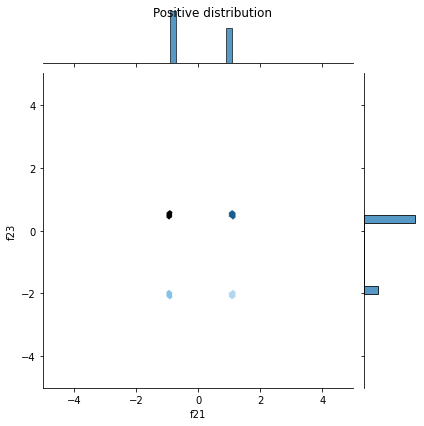

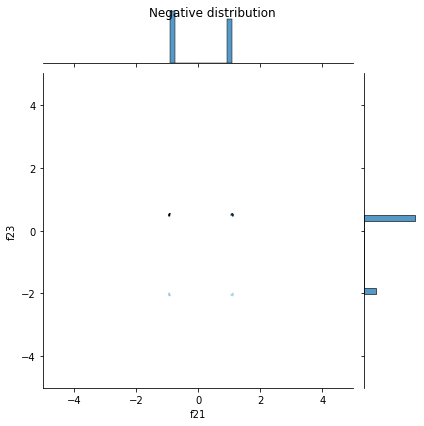

In [6]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['f21'], pos_df['f23'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['f21'], neg_df['f23'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

# MODEL

In [21]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

all_inputs = []
encoded_features = []

# Numeric features.
for header in df_pre.columns:
    # leave target as it is
    if header == "target":
        continue
    # encode discrete columns as one-hot vector
    elif header in dis_col_maped:
        discrete_col = tf.keras.Input(shape=(1,), name=header, dtype='int32')
        encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int32')
        encoded_discrete_col = encoding_layer(discrete_col)
        all_inputs.append(discrete_col)
        encoded_features.append(encoded_discrete_col)
    # normalize numeric columns (all with float32 type)
    else:    
        numeric_col = tf.keras.Input(shape=(1,), name=header)
        normalization_layer = get_normalization_layer(header, train_ds)
        encoded_numeric_col = normalization_layer(numeric_col)
        all_inputs.append(numeric_col)
        encoded_features.append(encoded_numeric_col)

In [4]:
train, test = train_test_split(df_pre, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

4412 train examples
1103 validation examples
1379 test examples


In [6]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [9]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['f1'])
print('A batch of targets:', label_batch )

Every feature: ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26']
A batch of ages: tf.Tensor([3 3 4 3 4], shape=(5,), dtype=int32)
A batch of targets: tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int32)


In [13]:
photo_count_col = train_features['f4']
layer = get_normalization_layer('f4', train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.67655206],
       [-0.18468577],
       [ 0.92823285],
       [ 1.1191088 ],
       [ 1.5367595 ]], dtype=float32)>

In [20]:
type_col = train_features['f2']
layer = get_category_encoding_layer('f2', train_ds, 'int32')
layer(type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)>

In [34]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(64, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.7)(x)
    x = tf.keras.layers.Dense(16, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid", bias_initializer=output_bias)(x)

    model = tf.keras.Model(all_inputs, output)
    
    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model


In [24]:
EPOCHS = 100
BATCH_SIZE = 64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

\\filestore.soton.ac.uk\users\fk1g19\.conda\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


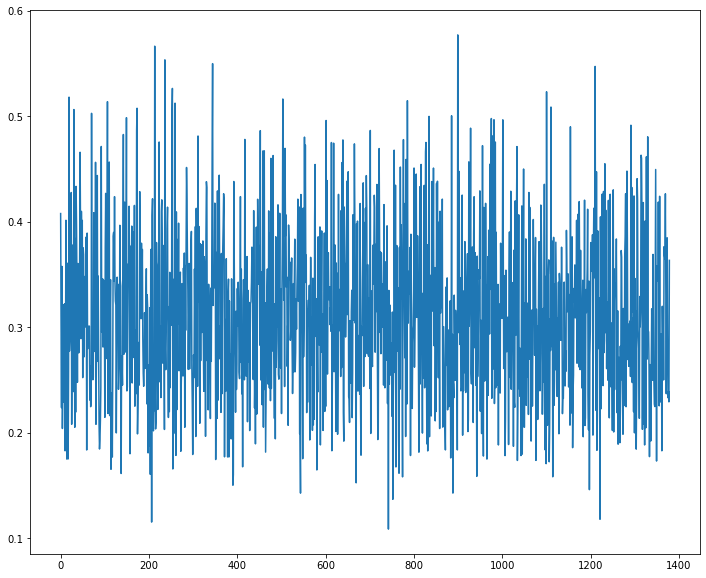

In [35]:
model = make_model()

plt.plot(model.predict(test_ds))

In [38]:
results = model.evaluate(train_ds, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4567


In [39]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.26410371])

\\filestore.soton.ac.uk\users\fk1g19\.conda\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


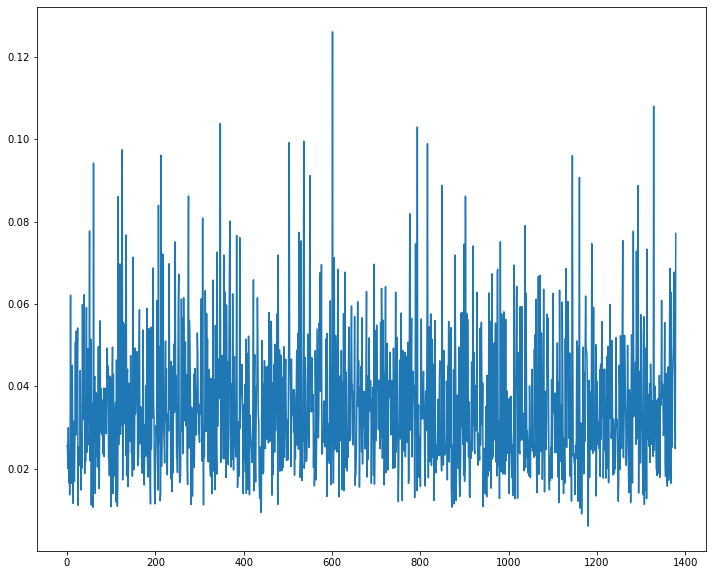

In [40]:
model = make_model(output_bias=initial_bias)

plt.plot(model.predict(test_ds))

In [41]:
results = model.evaluate(train_ds, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3526


In [42]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [48]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_ds, 
    verbose=0)

In [49]:
model = make_model(output_bias = initial_bias)
model.load_weights(initial_weights)
careful_bias_history  = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=val_ds, 
    verbose=0)

In [50]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

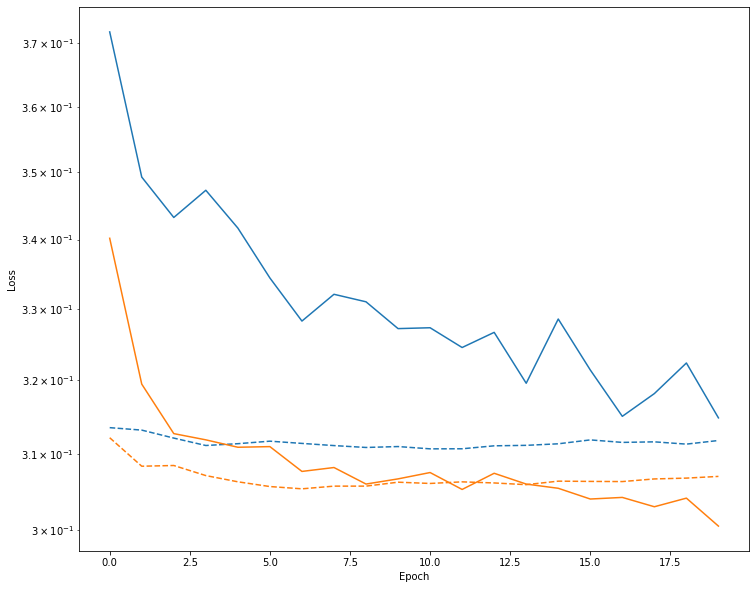

In [51]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [52]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
69/69 [==============================] - 4s 23ms/step - loss: 0.3425 - tp: 0.0000e+00 - fp: 1.0000 - tn: 5002.0000 - fn: 512.0000 - accuracy: 0.9070 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4810 - prc: 0.0857 - val_loss: 0.3117 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1002.0000 - val_fn: 101.0000 - val_accuracy: 0.9084 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5001 - val_prc: 0.0903
Epoch 2/100
69/69 [==============================] - 0s 2ms/step - loss: 0.3179 - tp: 0.0000e+00 - fp: 1.0000 - tn: 4000.0000 - fn: 411.0000 - accuracy: 0.9066 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5277 - prc: 0.0978 - val_loss: 0.3097 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1002.0000 - val_fn: 101.0000 - val_accuracy: 0.9084 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5019 - val_prc: 0.0898
Epoch 3/100
69/69 [==============================] - 0s 2ms/step - loss: 0.3145 - tp: 0.0000e+00 - fp: 0.0000

69/69 [==============================] - 0s 2ms/step - loss: 0.3027 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4001.0000 - fn: 411.0000 - accuracy: 0.9068 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6185 - prc: 0.1368 - val_loss: 0.3055 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1002.0000 - val_fn: 101.0000 - val_accuracy: 0.9084 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5343 - val_prc: 0.1077
Epoch 20/100
69/69 [==============================] - 0s 2ms/step - loss: 0.3018 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4001.0000 - fn: 411.0000 - accuracy: 0.9068 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6228 - prc: 0.1452 - val_loss: 0.3050 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1002.0000 - val_fn: 101.0000 - val_accuracy: 0.9084 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5369 - val_prc: 0.1058
Epoch 21/100
69/69 [==============================] - 0s 2ms/step - loss: 0.3029 - tp: 0.0000e+00 - fp: 0.0000e+0

In [53]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

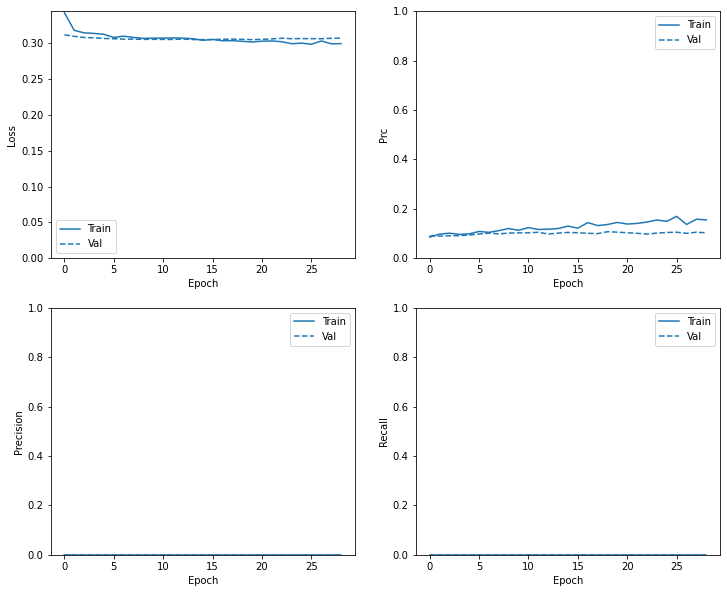

In [54]:
plot_metrics(baseline_history)

In [55]:
train_predictions_baseline = model.predict(train_ds, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_ds, batch_size=BATCH_SIZE)

In [56]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.3241405785083771
tp :  0.0
fp :  0.0
tn :  1242.0
fn :  137.0
accuracy :  0.9006526470184326
precision :  0.0
recall :  0.0
auc :  0.5225825309753418
prc :  0.10213269293308258

Legitimate Transactions Detected (True Negatives):  1242
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  137
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  137


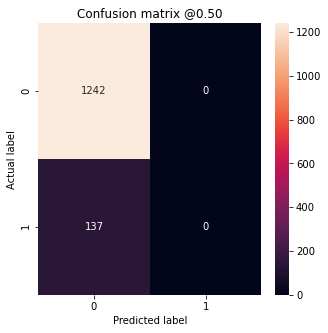

In [58]:
baseline_results = model.evaluate(test_ds, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [61]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([0,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

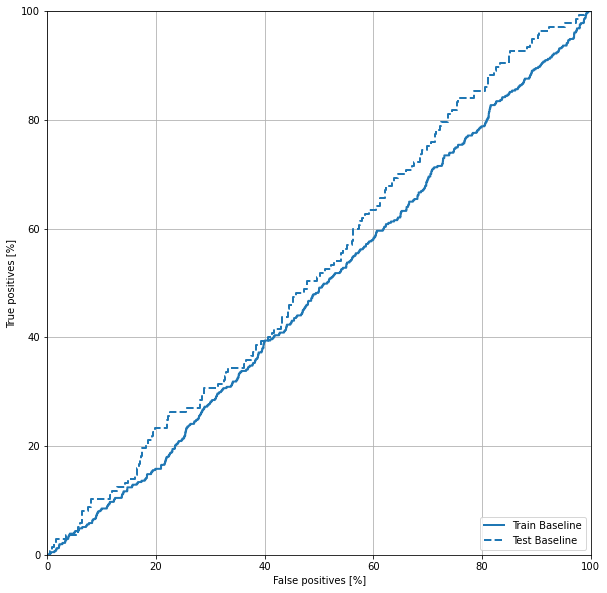

In [62]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [63]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

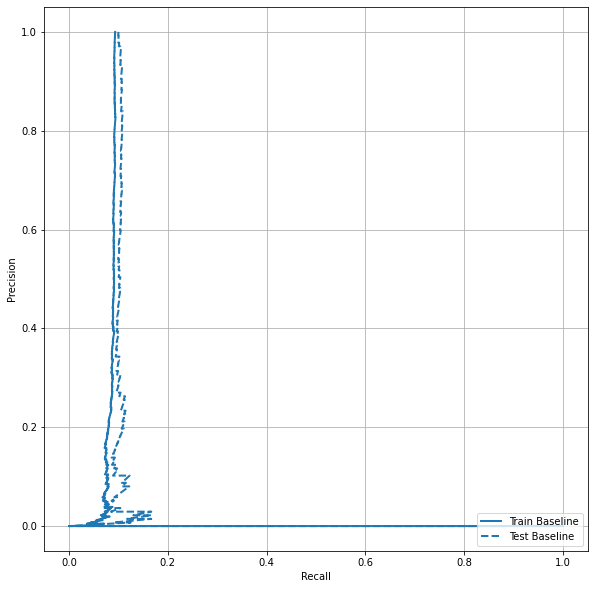

In [64]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [65]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.31


In [66]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_ds,
    # The class weights go here
    class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


\\filestore.soton.ac.uk\users\fk1g19\.conda\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
69/69 [==============================] - 4s 24ms/step - loss: 1.2703 - tp: 7.0000 - fp: 99.0000 - tn: 5144.0000 - fn: 541.0000 - accuracy: 0.8895 - precision: 0.0660 - recall: 0.0128 - auc: 0.5031 - prc: 0.0929 - val_loss: 0.3886 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 1001.0000 - val_fn: 101.0000 - val_accuracy: 0.9075 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5121 - val_prc: 0.0978
Epoch 2/100
69/69 [==============================] - 0s 2ms/step - loss: 0.8691 - tp: 103.0000 - fp: 1000.0000 - tn: 3001.0000 - fn: 308.0000 - accuracy: 0.7035 - precision: 0.0934 - recall: 0.2506 - auc: 0.5015 - prc: 0.0926 - val_loss: 0.5443 - val_tp: 21.0000 - val_fp: 148.0000 - val_tn: 854.0000 - val_fn: 80.0000 - val_accuracy: 0.7933 - val_precision: 0.1243 - val_recall: 0.2079 - val_auc: 0.5228 - val_prc: 0.1067
Epoch 3/100
69/69 [==============================] - 0s 2ms/step - loss: 0.8340 - tp: 145.0000 - fp: 1384.0000 - tn: 2617.0000 - fn: 266.0000 - ac

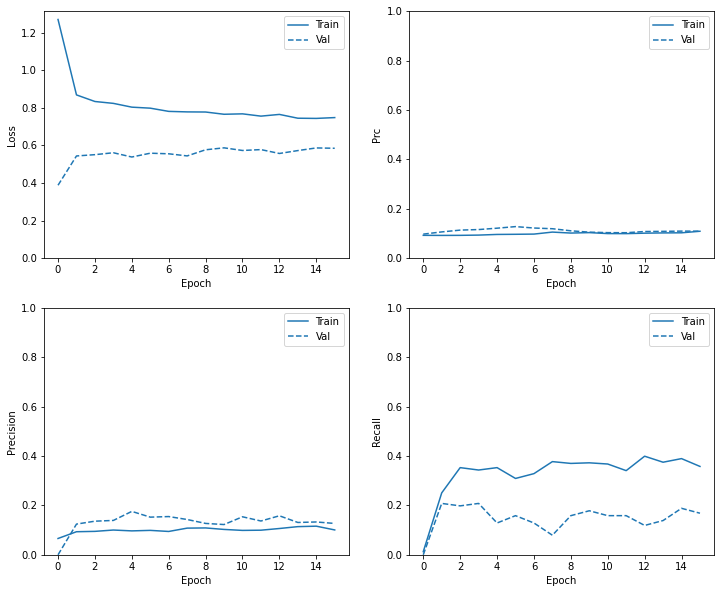

In [67]:
plot_metrics(weighted_history)


In [68]:
train_predictions_weighted = weighted_model.predict(train_ds, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_ds, batch_size=BATCH_SIZE)

loss :  0.5694453716278076
tp :  12.0
fp :  118.0
tn :  1124.0
fn :  125.0
accuracy :  0.8237853646278381
precision :  0.0923076942563057
recall :  0.08759123831987381
auc :  0.5031941533088684
prc :  0.09723955392837524

Legitimate Transactions Detected (True Negatives):  1124
Legitimate Transactions Incorrectly Detected (False Positives):  118
Fraudulent Transactions Missed (False Negatives):  125
Fraudulent Transactions Detected (True Positives):  12
Total Fraudulent Transactions:  137


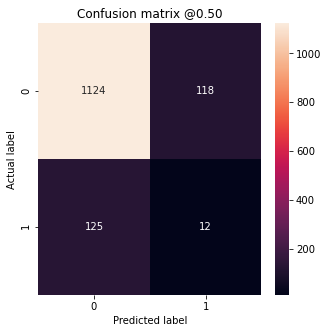

In [69]:
weighted_results = weighted_model.evaluate(test_ds,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

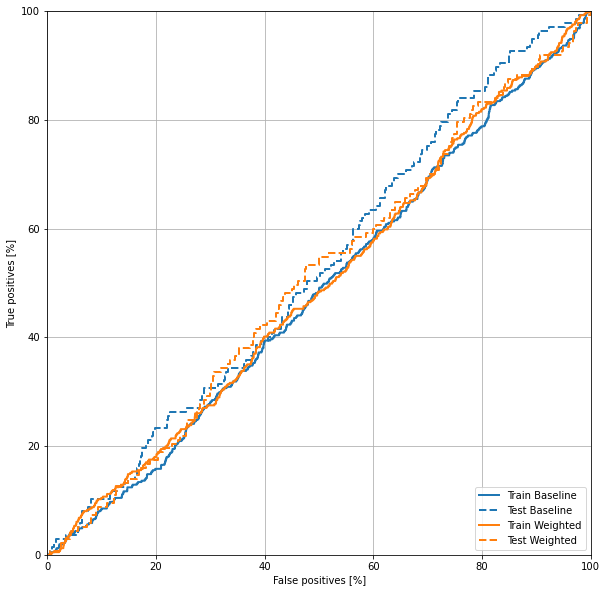

In [70]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

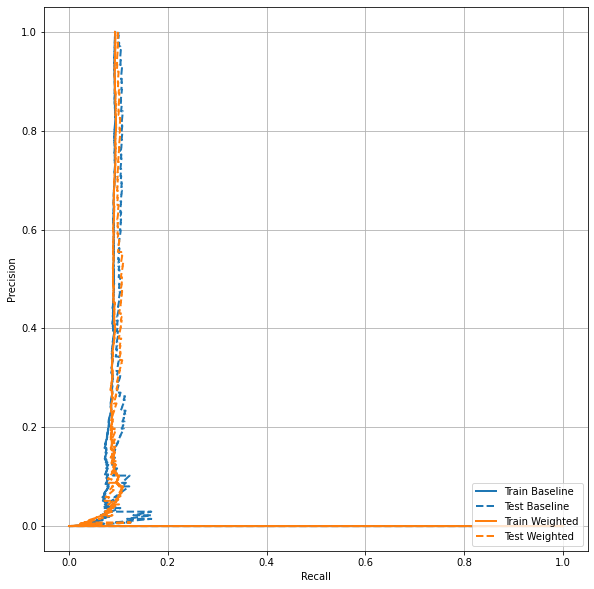

In [71]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

# Oversampling

In [96]:
pos_features = train_features[~bool_train_labels]
neg_features = train_features[bool_train_labels]

pos_labels = train_labels[~bool_train_labels]
neg_labels = train_labels[bool_train_labels]

In [73]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(4001, 26)

In [74]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(8002, 26)

In [390]:
resampled_features[0].shape

(26,)

In [75]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [380]:
next(iter(neg_ds))


(<tf.Tensor: shape=(26,), dtype=float64, numpy=
 array([4.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.66660571e+00,
        0.00000000e+00, 1.21174670e+03, 3.56748474e+02, 5.00000000e+00,
        3.11558056e+00, 0.00000000e+00, 0.00000000e+00, 1.50000000e+01,
        0.00000000e+00, 3.97227402e+01, 1.51109147e+00, 0.00000000e+00,
        2.69100098e+02, 2.88941193e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        7.20325012e+01, 3.53127742e+00])>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>)

In [112]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [6.00000000e+00 0.00000000e+00 0.00000000e+00 3.37584114e+00
 0.00000000e+00 1.94066223e+03 5.89536552e+01 2.00000000e+00
 4.02223825e+00 0.00000000e+00 0.00000000e+00 1.30000000e+01
 0.00000000e+00 4.62460670e+01 2.05578849e-01 0.00000000e+00
 3.62549164e+02 4.67353535e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 9.18181305e+01 1.18545822e+02]

Label:  1


In [237]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds

In [238]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.0


In [239]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

196.0

In [240]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [391]:
resample_df = np.zeros(shape = (resampled_features.shape[0]+1,resampled_features.shape[1]+1))
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)
i = 0
for x, y in zip(resampled_features, resampled_labels): #zip(neg_ds.concatenate(pos_ds), np.arange(resampled_features.shape[0])):
    resample_df[i,0] = y
    resample_df[i, 1:] = x
    i= i+1

resample_df =pd.DataFrame(data=resample_df, columns=list(feature_map.values()))

In [394]:
resampled_train_df, resampled_test_df = train_test_split(resample_df, test_size=0.2)
resampled_train_df, resampled_val_df = train_test_split(resampled_train_df, test_size=0.2)
resampled_train_ds = df_to_dataset(resampled_train_df,shuffle=True, batch_size=BATCH_SIZE)
resampled_val_ds = df_to_dataset(resampled_val_df, shuffle=True, batch_size=BATCH_SIZE)
resampled_test_ds = df_to_dataset(resampled_test_df, shuffle=True, batch_size=BATCH_SIZE)

In [401]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

#val_ds_sample = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
#val_ds_sample = val_ds_sample.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_train_ds,
    epochs=EPOCHS,
    #steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=resampled_val_ds)

Epoch 1/100
81/81 [==============================] - 4s 16ms/step - loss: 0.4447 - tp: 2487.0000 - fp: 122.0000 - tn: 2724.0000 - fn: 1069.0000 - accuracy: 0.8140 - precision: 0.9532 - recall: 0.6994 - auc: 0.9571 - prc: 0.9649 - val_loss: 0.1197 - val_tp: 741.0000 - val_fp: 0.0000e+00 - val_tn: 540.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 2/100
81/81 [==============================] - 0s 2ms/step - loss: 0.1246 - tp: 2709.0000 - fp: 29.0000 - tn: 2277.0000 - fn: 106.0000 - accuracy: 0.9736 - precision: 0.9894 - recall: 0.9623 - auc: 0.9989 - prc: 0.9991 - val_loss: 0.0291 - val_tp: 741.0000 - val_fp: 0.0000e+00 - val_tn: 540.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 3/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0672 - tp: 2781.0000 - fp: 35.0000 - tn: 2271.0000 - fn: 34.0000 -

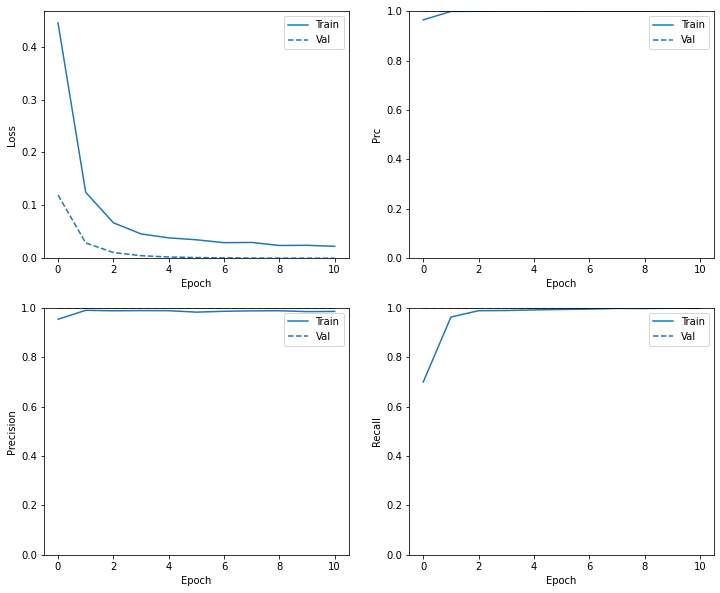

In [402]:
plot_metrics(resampled_history)


In [417]:
train_predictions_resampled = resampled_model.predict(resampled_train_ds, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(resampled_test_ds, batch_size=BATCH_SIZE)

In [419]:
resampled_results = resampled_model.evaluate(resampled_test_ds,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

loss :  0.11051187664270401
tp :  856.0
fp :  0.0
tn :  745.0
fn :  0.0
accuracy :  1.0
precision :  1.0
recall :  1.0
auc :  1.0
prc :  1.0



ValueError: Found input variables with inconsistent numbers of samples: [1379, 1601]

ValueError: Found input variables with inconsistent numbers of samples: [4412, 5121]

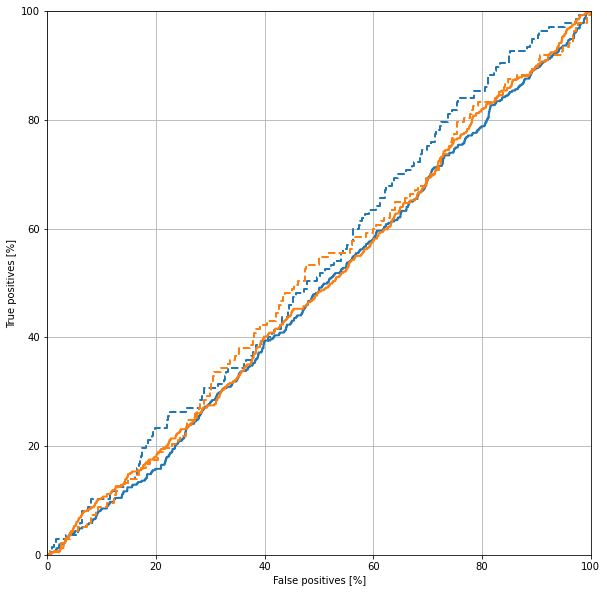

In [410]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

In [399]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_train_ds,
    epochs=10*EPOCHS,
    steps_per_epoch=20,
    callbacks=[early_stopping],
    validation_data=resampled_val_ds)

Epoch 1/1000
20/20 [==============================] - 4s 66ms/step - loss: 0.7708 - tp: 884.0000 - fp: 47.0000 - tn: 1064.0000 - fn: 566.0000 - accuracy: 0.7606 - precision: 0.9495 - recall: 0.6097 - auc: 0.9357 - prc: 0.9496 - val_loss: 0.5395 - val_tp: 204.0000 - val_fp: 0.0000e+00 - val_tn: 540.0000 - val_fn: 537.0000 - val_accuracy: 0.5808 - val_precision: 1.0000 - val_recall: 0.2753 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 2/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.4808 - tp: 365.0000 - fp: 20.0000 - tn: 555.0000 - fn: 340.0000 - accuracy: 0.7188 - precision: 0.9481 - recall: 0.5177 - auc: 0.9435 - prc: 0.9428 - val_loss: 0.3186 - val_tp: 651.0000 - val_fp: 0.0000e+00 - val_tn: 540.0000 - val_fn: 90.0000 - val_accuracy: 0.9297 - val_precision: 1.0000 - val_recall: 0.8785 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 3/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.3006 - tp: 551.0000 - fp: 17.0000 - tn: 578.0000 - fn: 134.0000 - accurac

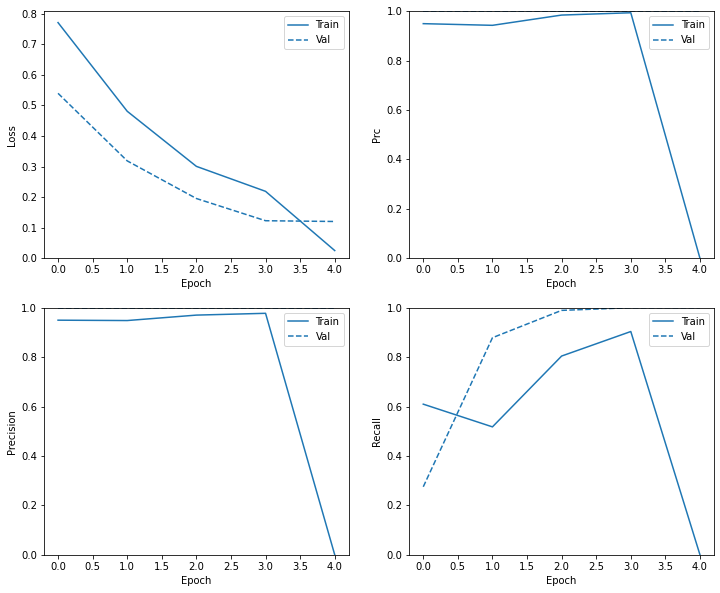

In [400]:
plot_metrics(resampled_history)


In [52]:
# rankdir='LR' is used to make the graph horizontal.
#tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [53]:
model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10
69/69 [==============================] - 4s 19ms/step - loss: 0.4513 - tp: 28.0000 - fp: 277.0000 - tn: 3724.0000 - fn: 383.0000 - accuracy: 0.8504 - precision: 0.0918 - recall: 0.0681 - auc: 0.5202 - prc: 0.0964 - val_loss: 0.3169 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1000.0000 - val_fn: 103.0000 - val_accuracy: 0.9066 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5513 - val_prc: 0.1060
Epoch 2/10
69/69 [==============================] - 0s 2ms/step - loss: 0.3757 - tp: 3.0000 - fp: 20.0000 - tn: 3981.0000 - fn: 408.0000 - accuracy: 0.9030 - precision: 0.1304 - recall: 0.0073 - auc: 0.5155 - prc: 0.0981 - val_loss: 0.3112 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1000.0000 - val_fn: 103.0000 - val_accuracy: 0.9066 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5541 - val_prc: 0.1092
Epoch 3/10
69/69 [==============================] - 0s 2ms/step - loss: 0.3671 - tp: 1.0000 - fp: 12.0000 - tn: 3989.0000 - fn: 410

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import IntegerLookup
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

df_pre = pd.read_csv("data/formatted_medical7_aug5.csv",header=0, sep="\,")
selected_features = np.load("f4.npy")
# drop first columns as they are redundant 
df_pre.drop('Unnamed: 0', axis = 1, inplace = True)

#keep only selected columns
target ="Graft loss 1 year"
df_pre = df_pre[[target] + list(selected_features)]

discrete_columns = [
    'AB and Dr mismatch',
    'AKI - KDIGO 2012',
    'Acute RRT initiation',
    'Another urosepsis 1 year',
    'Charlston Comorbidity Index',
    'Donor',
    'FSGS',
    'GCS',
    'Induction',
    'Next UTI - 6 months',
    'Reduction 3--> 2',
    'Reduction to steroid only',
    'Steroid bolus',
    'Transfusion [YES/NO]',
    'Tripple maintenance therapy before admission',
    'Urinary sepsis'
]


feature_map = {}
rev_map = {}
i = 1
for col in df_pre.columns:
    if col == target:
        feature_map[col] = "target"
        rev_map["target"] = col
    else:
        feature_map[col] = "f"+ str(i)
        rev_map["f"+ str(i)] = col
        i = i+1
        
dis_col_maped = [feature_map[col] for col in discrete_columns]
df_pre = df_pre.rename(columns=feature_map)



#show impalanced in the dataset
neg, pos = np.bincount(df_pre["target"])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

#convert 64 types to 32
for k, v in zip(list(df_pre.columns), list(df_pre.dtypes)):
    if(v== np.float64):
        df_pre[k] = df_pre[k].astype('float32')
    if(v==np.int64):
        df_pre[k] = df_pre[k].astype('int32')
        
#fill_zero_by_mean('CIT [min]')
# convert int columne with two distincts to boolean 
#df_pre['Another urosepsis 1 year'] = df_pre['Another urosepsis 1 year'].astype('bool')
#df_pre['Next UTI - 6 months'] = df_pre['Next UTI - 6 months'].astype('bool')

# convert float target columne with two distincts to boolean 
df_pre["target"] = df_pre["target"].astype('int32')
for col in dis_col_maped:
    df_pre[col] = df_pre[col].astype('int32')

df_pre.describe()

train, test = train_test_split(df_pre, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['f1'])
print('A batch of targets:', label_batch )

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

photo_count_col = train_features['f4']
layer = get_normalization_layer('f4', train_ds)
layer(photo_count_col)

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

type_col = train_features['f2']
layer = get_category_encoding_layer('f2', train_ds, 'int32')
layer(type_col)

batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

all_inputs = []
encoded_features = []

# Numeric features.
for header in train.columns:
    # leave target as it is
    if header == "target":
        continue
    # encode discrete columns as one-hot vector
    elif header in dis_col_maped:
        discrete_col = tf.keras.Input(shape=(1,), name=header, dtype='int32')
        encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int32')
        encoded_discrete_col = encoding_layer(discrete_col)
        all_inputs.append(discrete_col)
        encoded_features.append(encoded_discrete_col)
    # normalize numeric columns (all with float32 type)
    else:    
        numeric_col = tf.keras.Input(shape=(1,), name=header)
        normalization_layer = get_normalization_layer(header, train_ds)
        encoded_numeric_col = normalization_layer(numeric_col)
        all_inputs.append(numeric_col)
        encoded_features.append(encoded_numeric_col)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(8, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

# rankdir='LR' is used to make the graph horizontal.
#tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


model.fit(train_ds, epochs=10, validation_data=val_ds)




